In [1]:
import numpy as np
import pandas as pd
import json
import string
import spacy
from collections import defaultdict, Counter
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

Load utterance-based reference chains.

In [2]:
with open('../data/chains-v2/train.json', 'r') as f:
    train_set = json.load(f)
    
with open('../data/chains-v2/val.json', 'r') as f:
    val_set = json.load(f)
    
with open('../data/chains-v2/test.json', 'r') as f:
    test_set = json.load(f)

Make sure all 30 image domains are represented in all splits.

In [3]:
for _set in [train_set, val_set, test_set]: 
    domains = set()
    for img_path in _set.keys():
        domain, _ = img_path.split('/')
        domains.add(domain)
    assert len(domains) == 30

image_domains = list(domains)

## Collect overall statistics

In [4]:
# Use same tokeniser deployed for dataset creation.
spacy_tokenizer = spacy.load('en_core_web_sm')

Split reference chains by image domain.

In [5]:
all_chains = {}
n_utt_bydomain = defaultdict(int)
chain_lens_bydomain = defaultdict(list)
utt_lens_bydomain = defaultdict(list)

for _set in [train_set, val_set, test_set]:  
    for img_path in _set:
        domain, _ = img_path.split('/')
        
        if img_path not in all_chains:
            all_chains[img_path] = {}
        
        for game_id in _set[img_path]: 
            
            if game_id not in all_chains[img_path]:
                all_chains[img_path][game_id] = []
            
            chain = _set[img_path][game_id]
            chain_lens_bydomain[domain].append(len(chain))

            for utt in _set[img_path][game_id]:
                tokens = [tok for tok in spacy_tokenizer(utt['Message_Text'])]
                n_utt_bydomain[domain] += 1
                utt_lens_bydomain[domain].append(len(tokens))
                
                all_chains[img_path][game_id].append(tokens)

Create dataframe with statistics aggregated over splits

In [6]:
df = pd.DataFrame(
    data={'domain': image_domains,
          'num utterances': [n_utt_bydomain[d] for d in image_domains],
          'num chains': [len(chain_lens_bydomain[d]) for d in image_domains],
          'num tokens': [sum(utt_lens_bydomain[d]) for d in image_domains],
          'avg utterance length': [np.mean(utt_lens_bydomain[d]) for d in image_domains],
          'stdev utterance length': [np.std(utt_lens_bydomain[d]) for d in image_domains],
          'median utterance length': [np.median(utt_lens_bydomain[d]) for d in image_domains],
          'avg chain length': [np.mean(chain_lens_bydomain[d]) for d in image_domains],
          'stdev chain length': [np.std(chain_lens_bydomain[d]) for d in image_domains],
          'median chain length': [np.median(chain_lens_bydomain[d]) for d in image_domains]
         })

----

In [7]:
df.mean()

num utterances              1664.833333
num chains                   602.000000
num tokens                 16606.766667
avg utterance length           9.988148
stdev utterance length         5.003261
median utterance length        9.333333
avg chain length               2.764350
stdev chain length             1.042499
median chain length            3.000000
dtype: float64

In [8]:
df.std()

num utterances              371.064832
num chains                  132.610916
num tokens                 3763.235261
avg utterance length          0.571057
stdev utterance length        0.188827
median utterance length       0.802296
avg chain length              0.054984
stdev chain length            0.044876
median chain length           0.000000
dtype: float64

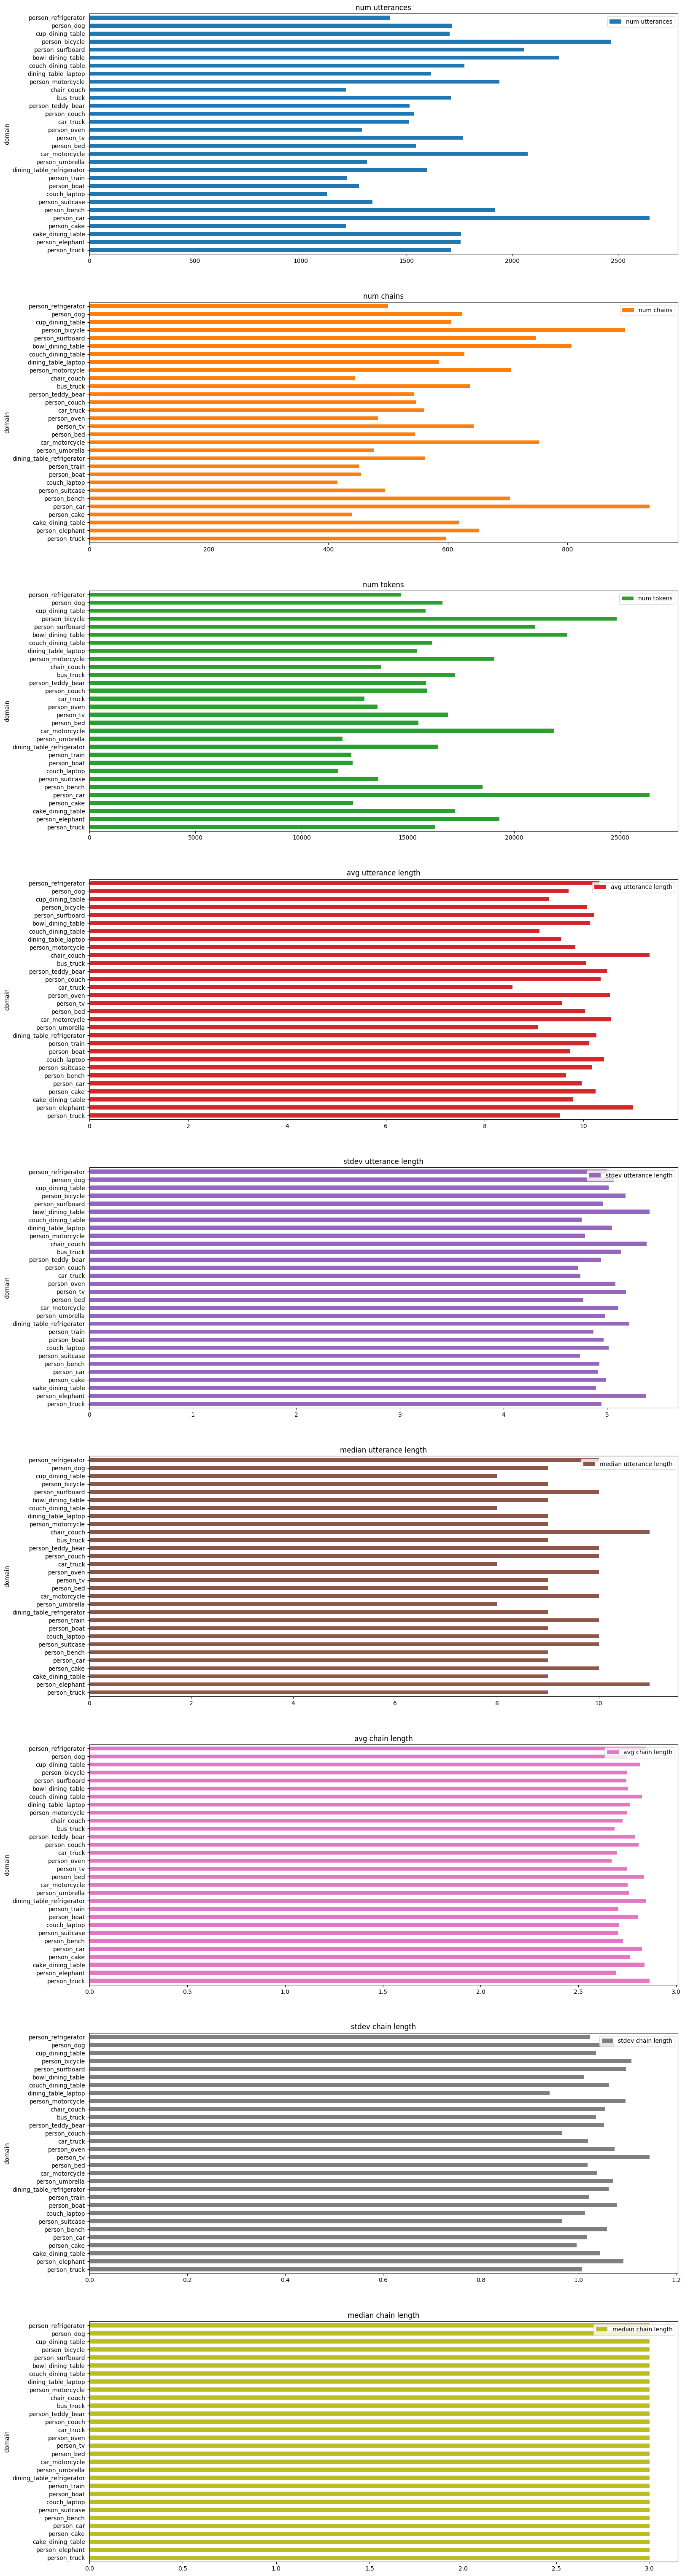

In [9]:
plt.rcParams['figure.figsize'] = [18, 80]
plt.rcParams['figure.dpi'] = 100
ax = df.plot(x='domain', kind='barh', subplots=True, sharex=False)

-----

## Domain vocabularies

In [10]:
vocabs = {d: Counter() for d in image_domains}

In [11]:
for img_path in all_chains:
    domain, _ = img_path.split('/')  
    for game_id in all_chains[img_path]:        
        for utt in all_chains[img_path][game_id]:
            for token in utt:
                vocabs[domain][token.text.lower()] += 1

Remove stopwords, numeric expressions, and punctuation.

In [12]:
stopwords_en = spacy.lang.en.stop_words.STOP_WORDS
stopwords_en |= {'no', 'noo', 'nope', 'yes', 'yeah', 'ok', 'oh', 'ha', 'i', 'you', ' '}
punctuation = set(string.punctuation)

stopword = lambda x: x in stopwords_en or x.isnumeric() or all([c in punctuation for c in x])

In [13]:
vocabs_clean = {}
for d in image_domains:
    vocabs_clean[d] = Counter({w: fr for w, fr in vocabs[d].items() if not stopword(w)})  # and fr > 1})

Compute type-token ratio by domain

In [14]:
n_types = np.zeros((len(image_domains)))
n_tokens = np.zeros((len(image_domains)))
ttr = np.zeros((len(image_domains)))

for i, d in enumerate(image_domains):
    n_types[i] = len(vocabs_clean[d])
    n_tokens[i] = sum(list(vocabs_clean[d].values()))
    ttr[i] = n_types[i] / n_tokens[i]
    
df_vocab = pd.DataFrame(
    data={'domain': image_domains,
          'num types': n_types,
          'num tokens': n_tokens,
          'TTR': ttr
         })

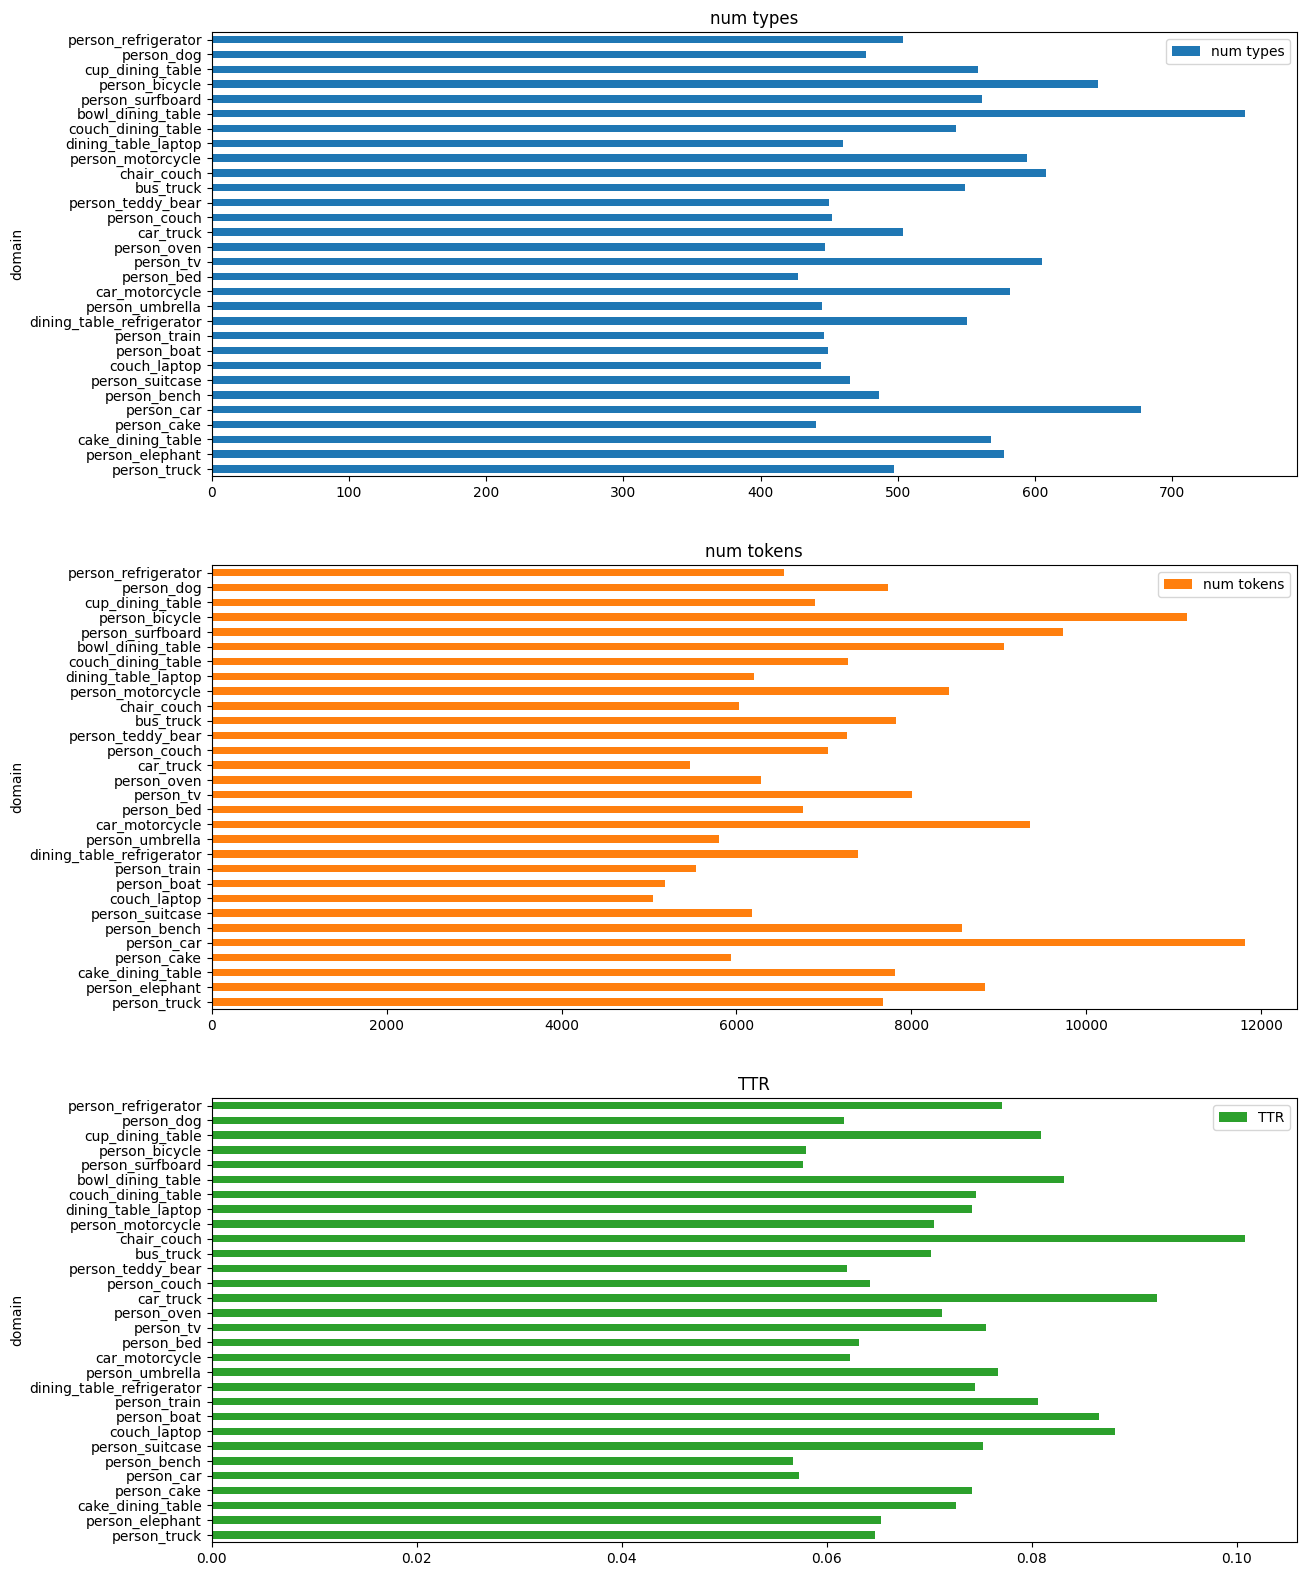

In [15]:
plt.rcParams['figure.figsize'] = [14, 20]
ax = df_vocab.plot(x='domain', kind='barh', subplots=True, sharex=False)

### Overlaps and differences between vocabularies

In [16]:
vocab_size_diffs = np.zeros((len(image_domains), len(image_domains)))
vocab_overlap = np.zeros((len(image_domains), len(image_domains)))
ttr_diffs = np.zeros((len(image_domains), len(image_domains)))

for i, d1 in enumerate(image_domains):
    vocab_set_d1 = set(vocabs_clean[d1])
    
    for j, d2 in enumerate(image_domains):
        vocab_set_d2 = set(vocabs_clean[d2])
        
        # Difference in vocab size
        vocab_size_diffs[i, j] = len(vocab_set_d1) - len(vocab_set_d2)
        
        # Percentage of vocabulary overlap
        overlap = vocab_set_d1 & vocab_set_d2
        universe = vocab_set_d1 | vocab_set_d2
        vocab_overlap[i, j] = float(len(overlap)) / len(universe) * 100
        
        # Difference in type-token ratio
        ttr_diffs[i, j] = ttr[i] - ttr[j]

In [17]:
plt.rcParams['figure.figsize'] = [12, 12]

Max difference: 326.0
Min difference: -326.0
Mean difference: 0.0
Stdev difference: 113.02252479533055


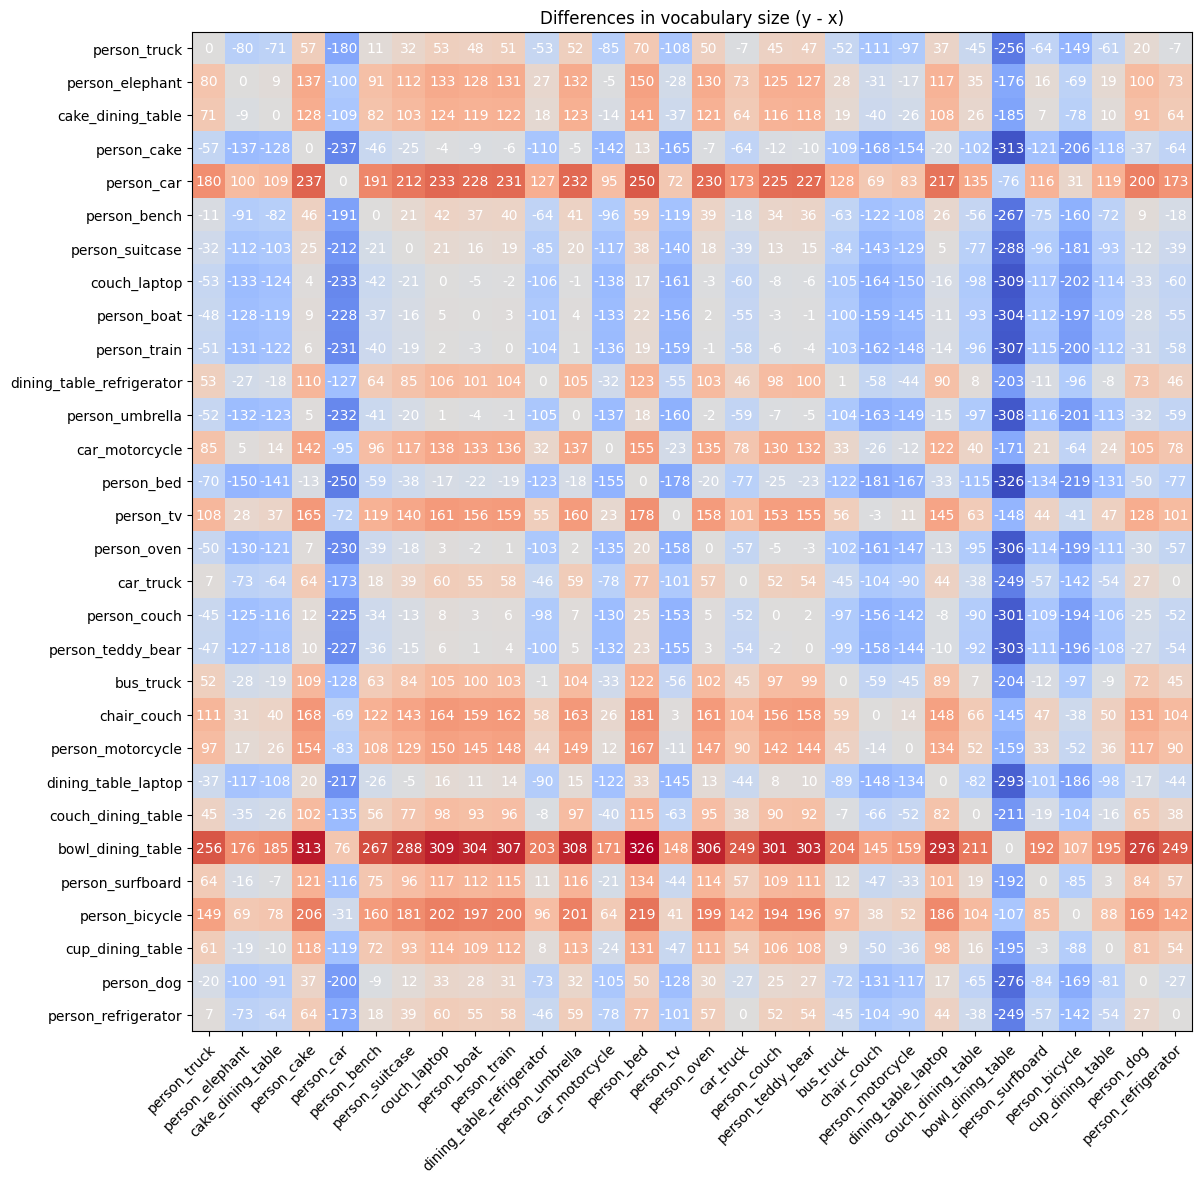

In [18]:
fig, ax = plt.subplots()
im = ax.imshow(vocab_size_diffs, cmap='coolwarm')

# We want to show all ticks...
ax.set_xticks(np.arange(len(image_domains)))
ax.set_yticks(np.arange(len(image_domains)))
# ... and label them with the respective list entries
ax.set_xticklabels(image_domains)
ax.set_yticklabels(image_domains)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(image_domains)):
    for j in range(len(image_domains)):
        text = ax.text(j, i, int(vocab_size_diffs[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Differences in vocabulary size (y - x)")
fig.tight_layout()
print('Max difference:', np.max(vocab_size_diffs))
print('Min difference:', np.min(vocab_size_diffs))
print('Mean difference:', np.mean(vocab_size_diffs))
print('Stdev difference:', np.std(vocab_size_diffs))
plt.show()

Max overlap: 100.0
Min overlap: 9.767441860465116
Mean overlap: 18.97185255376331
Stdev overlap: 15.258625068134643


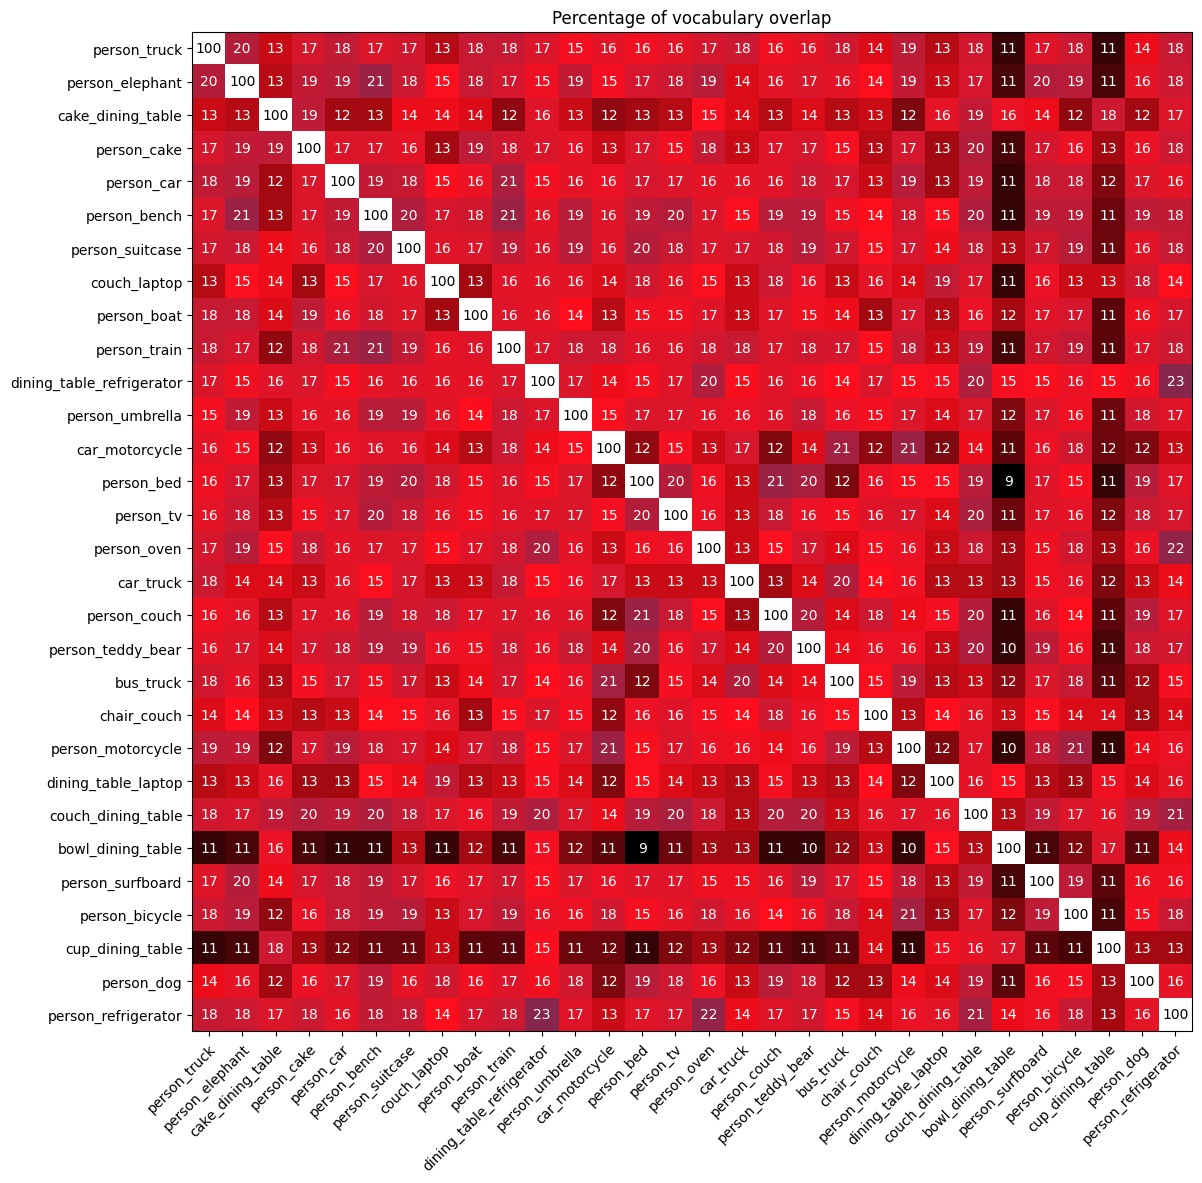

In [19]:
fig, ax = plt.subplots()
im = ax.imshow(vocab_overlap, cmap='gist_stern')

# We want to show all ticks...
ax.set_xticks(np.arange(len(image_domains)))
ax.set_yticks(np.arange(len(image_domains)))
# ... and label them with the respective list entries
ax.set_xticklabels(image_domains)
ax.set_yticklabels(image_domains)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(image_domains)):
    for j in range(len(image_domains)):
        text = ax.text(j, i, int(vocab_overlap[i, j]),
                       ha="center", va="center", color="w" if int(vocab_overlap[i, j]) < 100 else "black")

ax.set_title("Percentage of vocabulary overlap")
fig.tight_layout()
print('Max overlap:', np.max(vocab_overlap))
print('Min overlap:', np.min(vocab_overlap))
print('Mean overlap:', np.mean(vocab_overlap))
print('Stdev overlap:', np.std(vocab_overlap))
plt.show()

In [20]:
np.max(vocab_overlap[vocab_overlap != 100])

23.4192037470726

Max difference: 0.0441395804909509
Min difference: -0.0441395804909509
Mean difference: -6.167905692361981e-20
Stdev difference: 0.015227411982035673


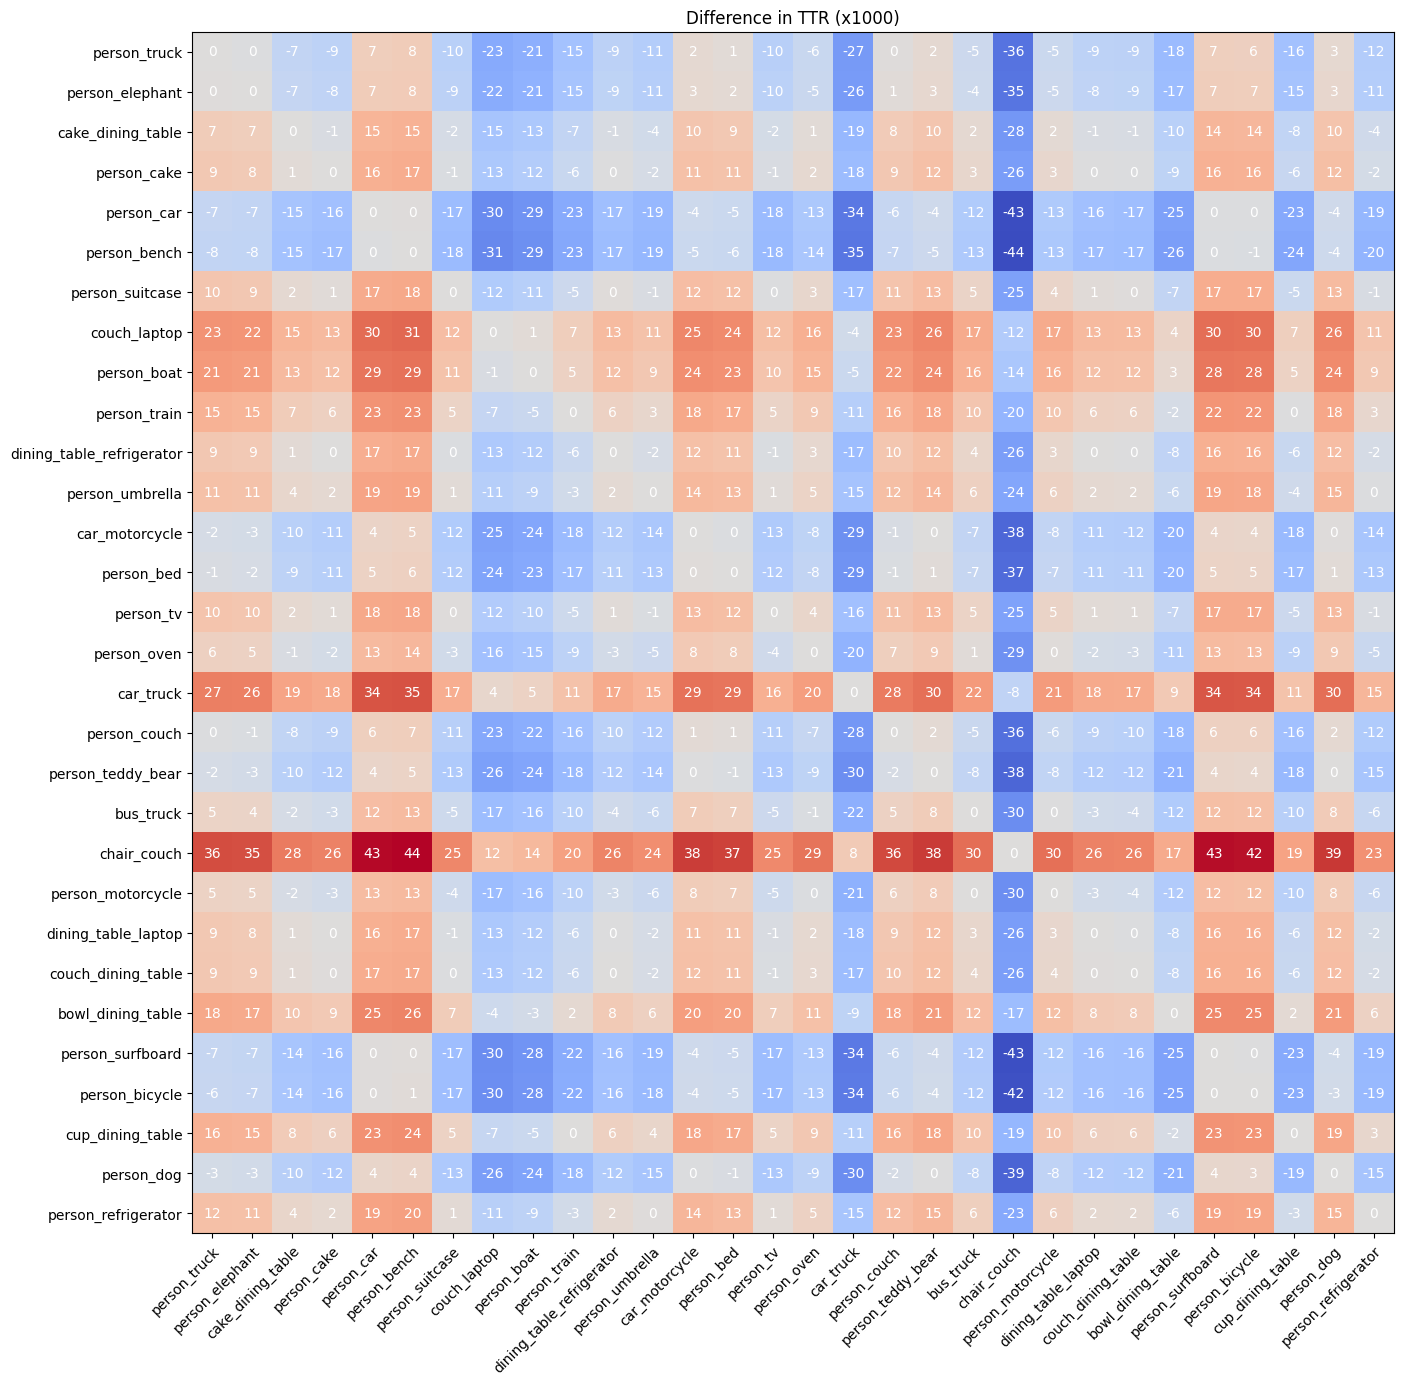

In [21]:
plt.rcParams['figure.figsize'] = [14, 14]
fig, ax = plt.subplots()
im = ax.imshow(ttr_diffs, cmap='coolwarm')

# We want to show all ticks...
ax.set_xticks(np.arange(len(image_domains)))
ax.set_yticks(np.arange(len(image_domains)))
# ... and label them with the respective list entries
ax.set_xticklabels(image_domains)
ax.set_yticklabels(image_domains)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(image_domains)):
    for j in range(len(image_domains)):
        text = ax.text(j, i, int(ttr_diffs[i, j] * 1000),
                       ha="center", va="center", color="w")

ax.set_title("Difference in TTR (x1000)")
fig.tight_layout()

print('Max difference:', np.max(ttr_diffs))
print('Min difference:', np.min(ttr_diffs))
print('Mean difference:', np.mean(ttr_diffs))
print('Stdev difference:', np.std(ttr_diffs))

plt.show()

### Overlap percentage statistics

In [22]:
relevant_overlaps = np.triu(vocab_overlap, k=1)
relevant_overlaps = relevant_overlaps[relevant_overlaps != 0]

In [23]:
mu = np.mean(relevant_overlaps)
sigma = np.std(relevant_overlaps)

print('Mean: %.2f' % mu)
print('Std:   %.2f' % sigma)
print('Max:  %.2f' % np.max(relevant_overlaps))
print('Min:   %.2f' % np.min(relevant_overlaps))

Mean: 16.18
Std:   2.58
Max:  23.42
Min:   9.77


NameError: name 'markers_on' is not defined

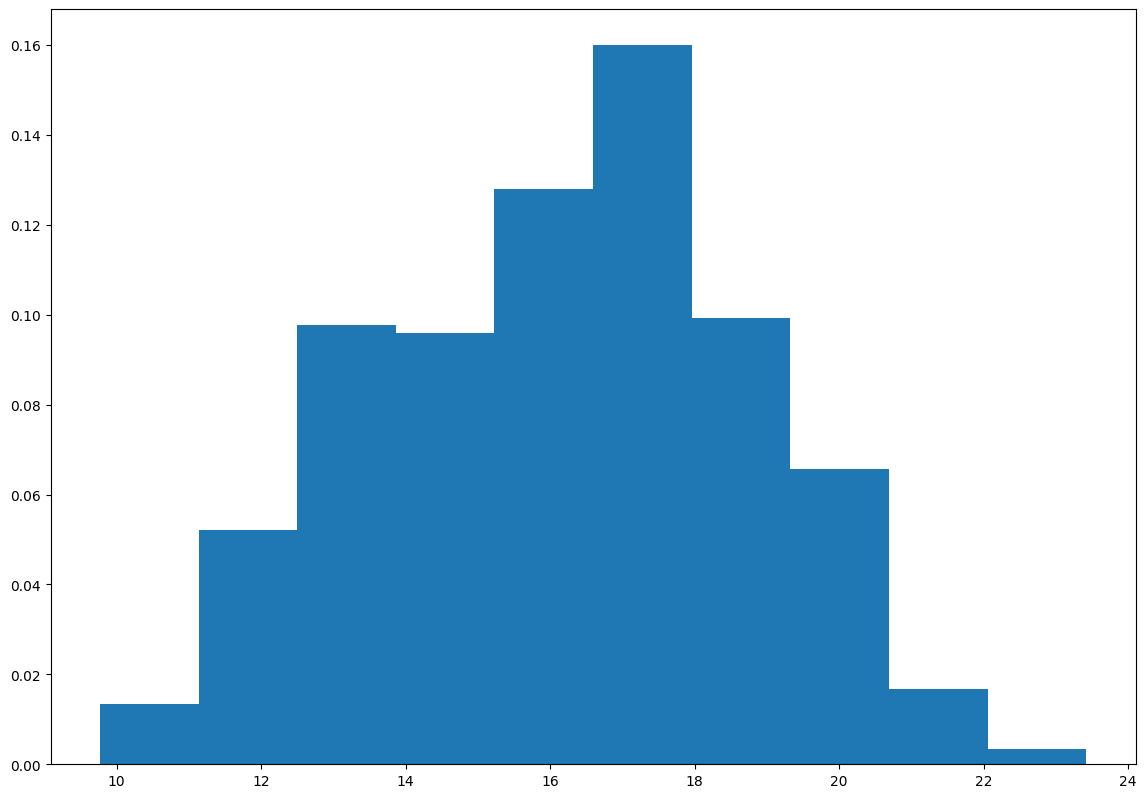

In [24]:
plt.rcParams['figure.figsize'] = [14, 10]
plt.hist(relevant_overlaps, density=True, bins=10)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), markevery=markers_on)

markers_on = [mu + s for s in [-3*sigma, -2*sigma, -sigma, sigma, 2*sigma, 3*sigma]]
for xc in markers_on:
    plt.axvline(x=xc, color='k', linestyle='--')
    
plt.show()

#### Significant overlaps

In [ ]:
significant_overlaps = defaultdict(list)
for i, d1 in enumerate(image_domains):    
    for j, d2 in enumerate(image_domains):
        if d1 == d2:
            continue
        for mul in [1, 2]:
            if vocab_overlap[i, j] > mu + mul * sigma and (d2, d1, vocab_overlap[i, j]) not in significant_overlaps[mul]:
                significant_overlaps[mul].append((d1, d2, vocab_overlap[i, j]))

for mul in [1, 2]:
    print('%d standard deviation(s)' % mul, len(significant_overlaps[mul]))
    for d1, d2, ov in significant_overlaps[mul]:
        print(d1, d2, '%.2f' % ov)
    print()

Merges that make most sense:
- person_oven, person_refrigerator
- person_bed, person_couch
- person_motorcycle, car_motorcycle
- dining_table_refrigerator, person_refrigerator

131.06748271972222 91.74723790380555


(array([ 1.,  1.,  2.,  3.,  4.,  5., 16., 17., 21., 19., 27., 34., 32.,
        33., 38., 11., 21., 12., 26., 26., 18., 13., 14.,  5.,  9.,  7.,
         5.,  9.,  4.,  2.]),
 array([108.57398886, 109.32377199, 110.07355512, 110.82333825,
        111.57312138, 112.32290451, 113.07268763, 113.82247076,
        114.57225389, 115.32203702, 116.07182015, 116.82160328,
        117.57138641, 118.32116953, 119.07095266, 119.82073579,
        120.57051892, 121.32030205, 122.07008518, 122.81986831,
        123.56965143, 124.31943456, 125.06921769, 125.81900082,
        126.56878395, 127.31856708, 128.06835021, 128.81813333,
        129.56791646, 130.31769959, 131.06748272]),
 <BarContainer object of 30 artists>)

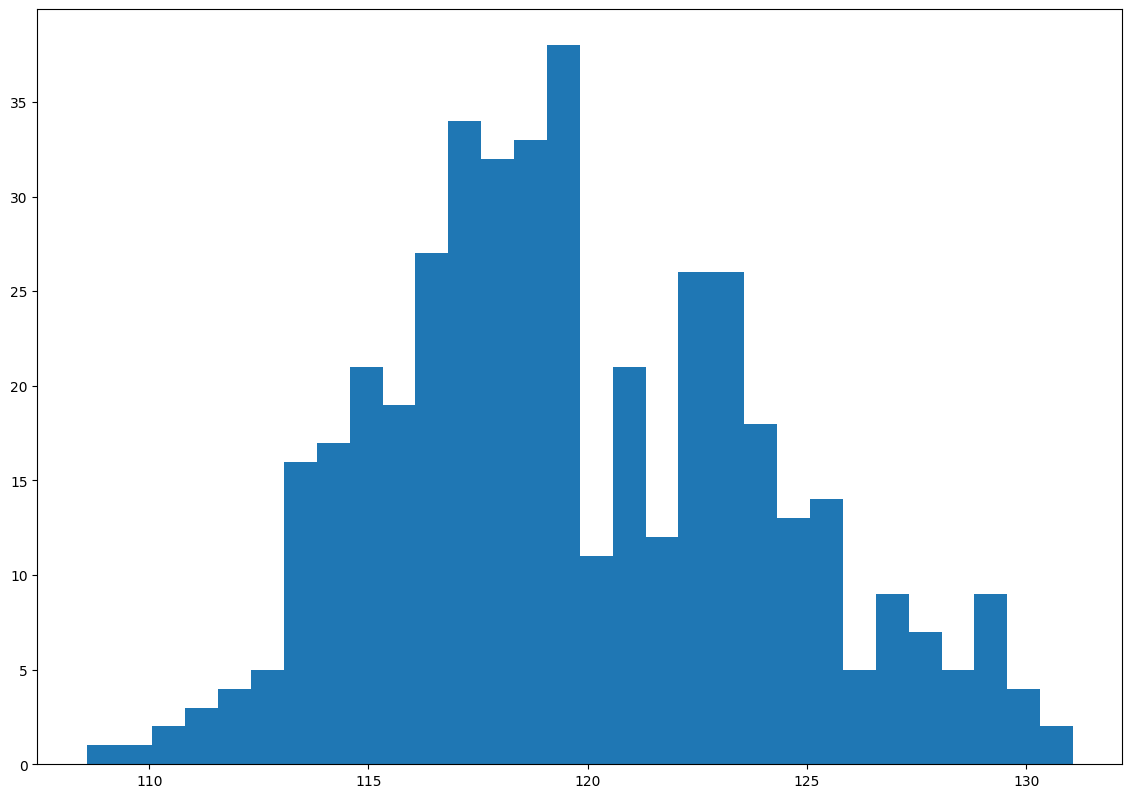

In [52]:
from scipy.spatial.distance import pdist
distances = pdist(vocab_overlap)
print(max(distances), 0.7 * max(distances))
plt.hist(distances, bins=30)

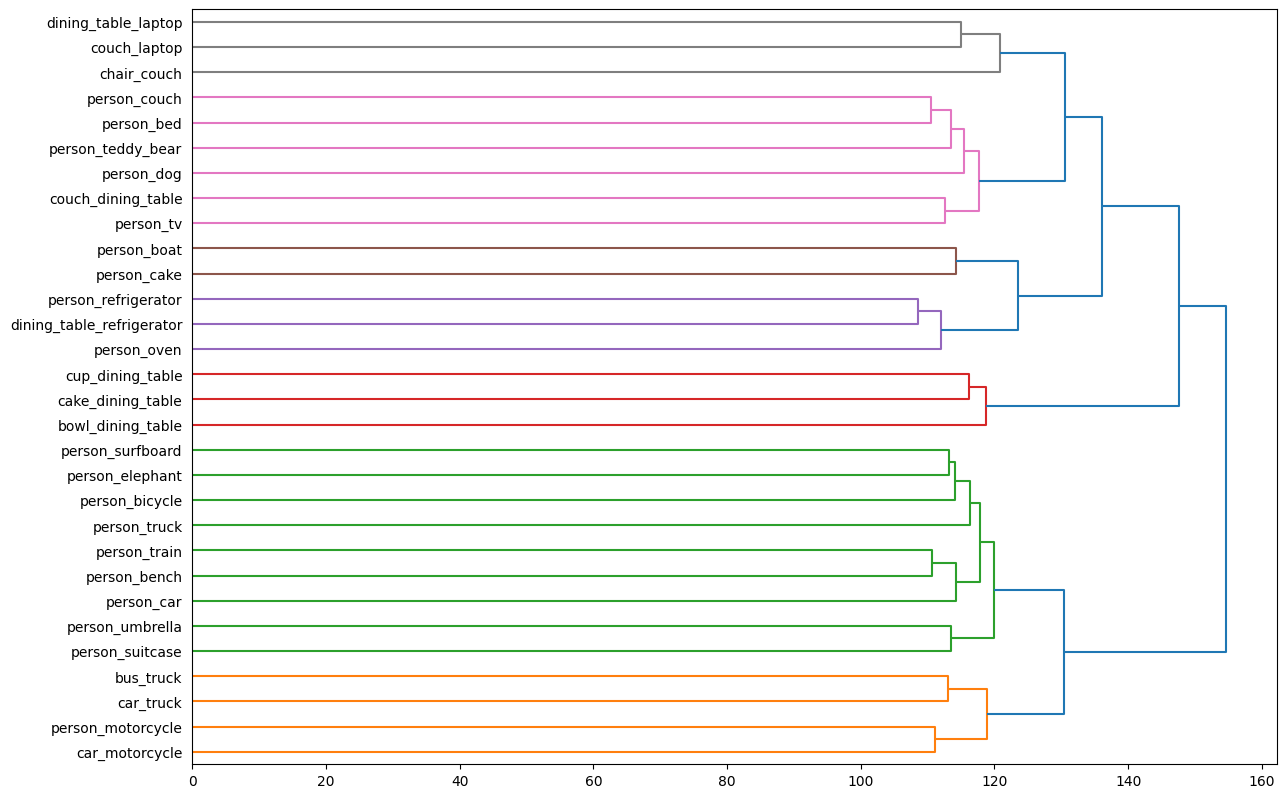

In [53]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs)
    
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)  #, affinity='precomputed', linkage='complete')
clustering = clustering.fit(vocab_overlap)

result = plot_dendrogram(clustering, labels=image_domains, orientation='right', distance_sort=True, color_threshold=123)

In [78]:
all_vocabs = Counter()
for domain in vocabs_clean:
    all_vocabs += vocabs_clean[domain]
    
all_words = list(all_vocabs.keys())
w2i = {w: i for i, w in enumerate(all_words)}
d2i = {d: i for i, d in enumerate(vocabs_clean.keys())}

vocab_vectors = np.zeros((len(vocabs_clean), len(all_words)))
for domain in vocabs_clean:
    for w in all_words:
        if w in vocabs_clean[domain]:
            vocab_vectors[d2i[domain]][w2i[w]] = vocabs_clean[domain][w] / sum(vocabs_clean[domain].values())

0.26247541150527076 0.18373278805368953


(array([ 1.,  3.,  1.,  1.,  1.,  3.,  6., 11., 12., 20., 18., 27., 33.,
        24., 29., 22., 25., 25., 27., 28., 25., 20., 23., 15.,  7., 11.,
         8.,  2.,  5.,  2.]),
 array([0.11346426, 0.1184313 , 0.12339834, 0.12836538, 0.13333241,
        0.13829945, 0.14326649, 0.14823353, 0.15320057, 0.15816761,
        0.16313464, 0.16810168, 0.17306872, 0.17803576, 0.1830028 ,
        0.18796984, 0.19293687, 0.19790391, 0.20287095, 0.20783799,
        0.21280503, 0.21777207, 0.2227391 , 0.22770614, 0.23267318,
        0.23764022, 0.24260726, 0.2475743 , 0.25254133, 0.25750837,
        0.26247541]),
 <BarContainer object of 30 artists>)

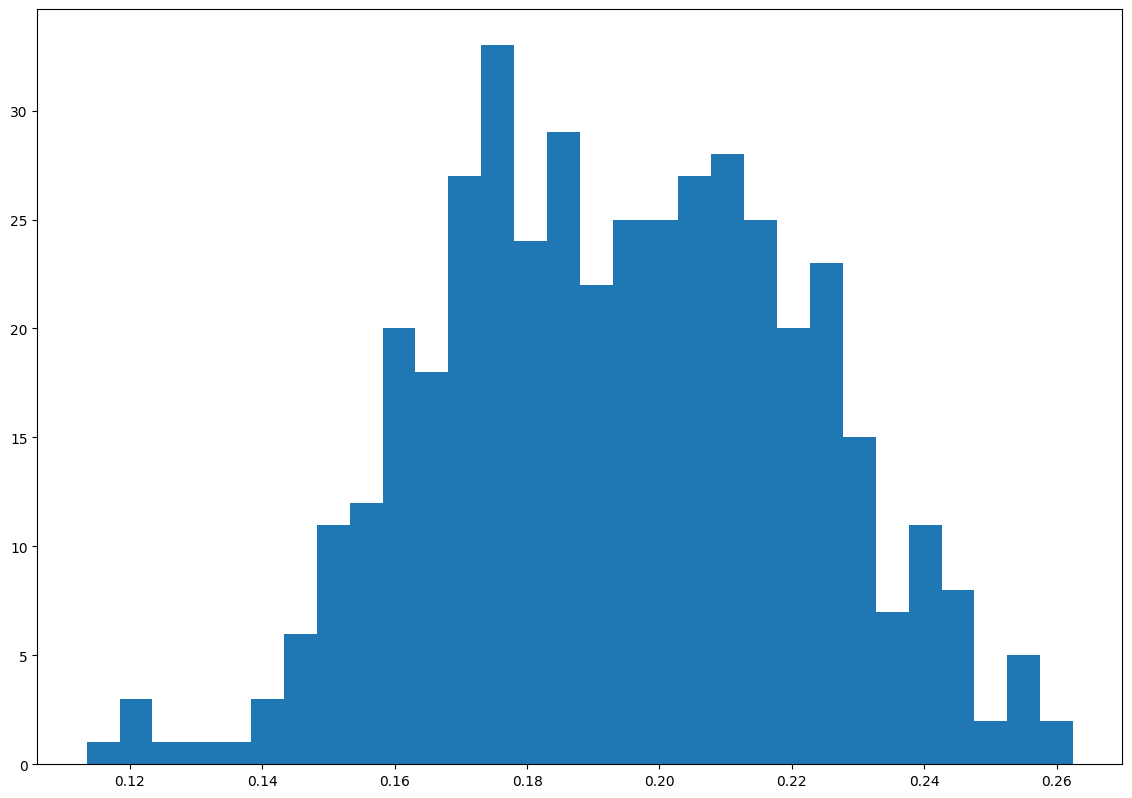

In [80]:
distances = pdist(vocab_vectors)
print(max(distances), 0.7 * max(distances))
plt.hist(distances, bins=30)

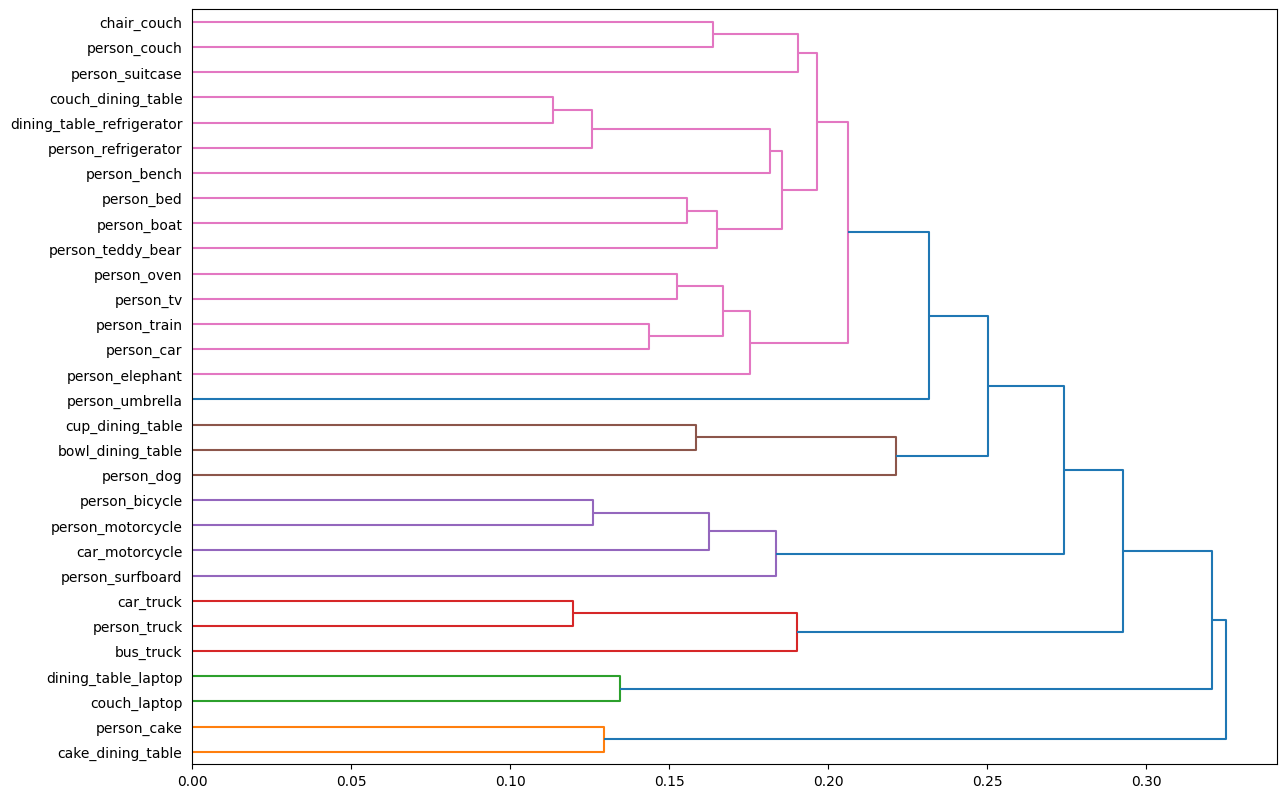

In [81]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)  #, affinity='precomputed', linkage='complete')
clustering = clustering.fit(vocab_vectors)

result = plot_dendrogram(clustering, labels=image_domains, orientation='right', distance_sort=True, color_threshold=0.23)

### Merge domains

#### Fine-grained domains

**Vehicles**  
person_motorcycle  
car_motorcycle  
bus_truck  
car_truck  

**Accessories**  
person_suitcase  
person_umbrella  

**Food**  
bowl_dining_table  
cup_dining_table  
cake_dining_table  

**Appliances**  
person_oven  
dining_table_refrigerator  
person_refrigerator  

**Laptops**  
dining_table_laptop  
couch_laptop  

**Bed and couch**  
person_bed  
person_couch

**Outdoor**  
person_surfboard  
person_elephant  
person_bicycle

In [31]:
merged_vocabs_clean = {
    'vehicles': vocabs_clean['person_motorcycle'] + vocabs_clean['car_motorcycle'] + vocabs_clean['bus_truck'] + vocabs_clean['car_truck'],
    'accessories': vocabs_clean['person_suitcase'] + vocabs_clean['person_umbrella'],
    'food': vocabs_clean['bowl_dining_table'] + vocabs_clean['cup_dining_table'] + vocabs_clean['cake_dining_table'],
    'appliances': vocabs_clean['person_oven'] + vocabs_clean['dining_table_refrigerator'] + vocabs_clean['person_refrigerator'],
    'laptops': vocabs_clean['dining_table_laptop'] + vocabs_clean['couch_laptop'],
    'bed-couch': vocabs_clean['person_bed'] + vocabs_clean['person_couch'],
    'outdoor': vocabs_clean['person_surfboard'] + vocabs_clean['person_elephant'] + vocabs_clean['person_bicycle']
}

In [32]:
merged_vocab_size_diffs = np.zeros((len(merged_vocabs_clean), len(merged_vocabs_clean)))
merged_vocab_overlap = np.zeros((len(merged_vocabs_clean), len(merged_vocabs_clean)))
merged_ttr_diffs = np.zeros((len(merged_vocabs_clean), len(merged_vocabs_clean)))

for i, d1 in enumerate(merged_vocabs_clean):
    vocab_set_d1 = set(merged_vocabs_clean[d1])
    
    for j, d2 in enumerate(merged_vocabs_clean):
        vocab_set_d2 = set(merged_vocabs_clean[d2])
        
        # Difference in vocab size
        merged_vocab_size_diffs[i, j] = len(vocab_set_d1) - len(vocab_set_d2)
        
        # Percentage of vocabulary overlap
        overlap = vocab_set_d1 & vocab_set_d2
        universe = vocab_set_d1 | vocab_set_d2
        merged_vocab_overlap[i, j] = float(len(overlap)) / len(universe) * 100
        
        # Difference in type-token ratio
        merged_ttr_diffs[i, j] = ttr[i] - ttr[j]

In [33]:
plt.rcParams['figure.figsize'] = [8, 8]

Max difference: 797.0
Min difference: -797.0
Mean difference: 0.0
Stdev difference: 451.98762851048326


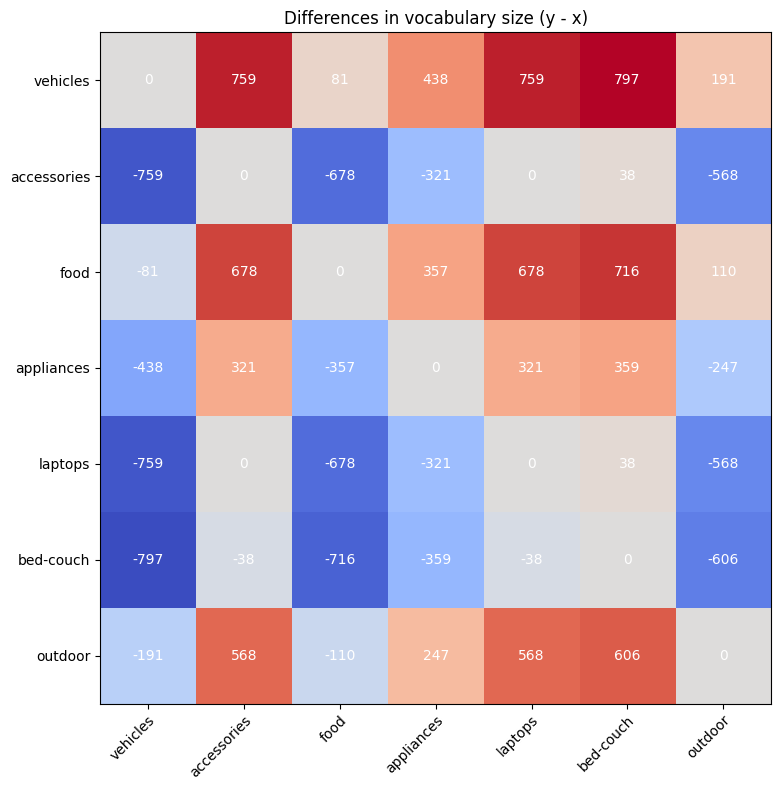

In [34]:
fig, ax = plt.subplots()
im = ax.imshow(merged_vocab_size_diffs, cmap='coolwarm')

# We want to show all ticks...
ax.set_xticks(np.arange(len(merged_vocabs_clean)))
ax.set_yticks(np.arange(len(merged_vocabs_clean)))
# ... and label them with the respective list entries
ax.set_xticklabels(merged_vocabs_clean.keys())
ax.set_yticklabels(merged_vocabs_clean.keys())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(merged_vocabs_clean)):
    for j in range(len(merged_vocabs_clean)):
        text = ax.text(j, i, int(merged_vocab_size_diffs[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Differences in vocabulary size (y - x)")
fig.tight_layout()

print('Max difference:', np.max(merged_vocab_size_diffs))
print('Min difference:', np.min(merged_vocab_size_diffs))
print('Mean difference:', np.mean(merged_vocab_size_diffs))
print('Stdev difference:', np.std(merged_vocab_size_diffs))

plt.show()

Max overlap: 100.0
Min overlap: 12.807109252483013
Mean overlap: 28.953832240506856
Stdev overlap: 29.076972777478463


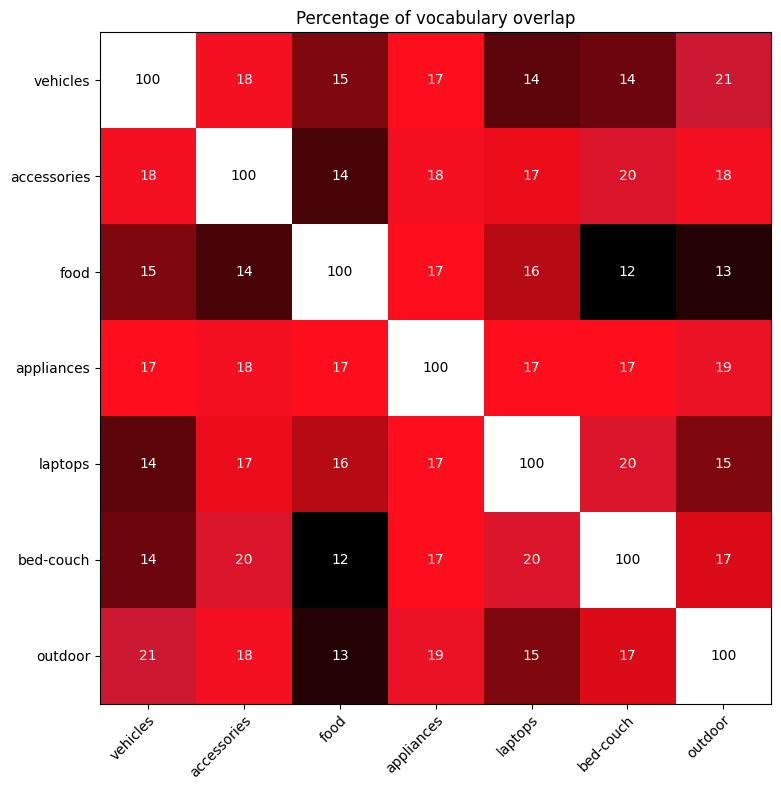

In [35]:
fig, ax = plt.subplots()
im = ax.imshow(merged_vocab_overlap, cmap='gist_stern')

# We want to show all ticks...
ax.set_xticks(np.arange(len(merged_vocabs_clean)))
ax.set_yticks(np.arange(len(merged_vocabs_clean)))
# ... and label them with the respective list entries
ax.set_xticklabels(merged_vocabs_clean.keys())
ax.set_yticklabels(merged_vocabs_clean.keys())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(merged_vocabs_clean)):
    for j in range(len(merged_vocabs_clean)):
        text = ax.text(j, i, int(merged_vocab_overlap[i, j]),
                       ha="center", va="center", color="w" if int(merged_vocab_overlap[i, j]) < 100 else "black")

ax.set_title("Percentage of vocabulary overlap")
fig.tight_layout()

print('Max overlap:', np.max(merged_vocab_overlap))
print('Min overlap:', np.min(merged_vocab_overlap))
print('Mean overlap:', np.mean(merged_vocab_overlap))
print('Stdev overlap:', np.std(merged_vocab_overlap))

plt.show()

Max difference: 0.012866986281623576
Min difference: -0.012866986281623576
Mean difference: 0.0
Stdev difference: 0.006751147286796245


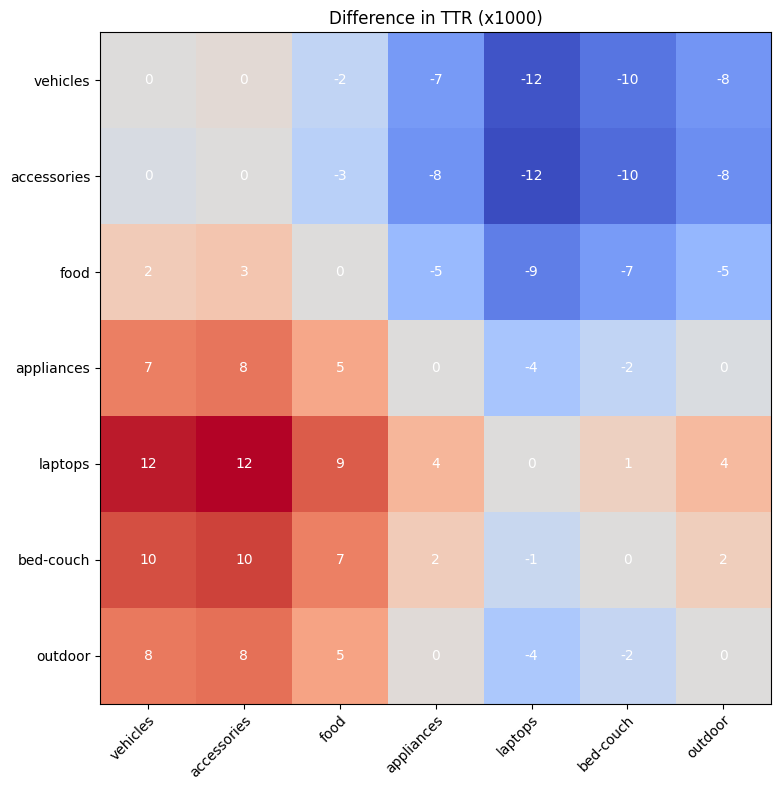

In [36]:
fig, ax = plt.subplots()
im = ax.imshow(merged_ttr_diffs, cmap='coolwarm')

# We want to show all ticks...
ax.set_xticks(np.arange(len(merged_vocabs_clean)))
ax.set_yticks(np.arange(len(merged_vocabs_clean)))
# ... and label them with the respective list entries
ax.set_xticklabels(merged_vocabs_clean.keys())
ax.set_yticklabels(merged_vocabs_clean.keys())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(merged_vocabs_clean)):
    for j in range(len(merged_vocabs_clean)):
        text = ax.text(j, i, int(merged_ttr_diffs[i, j] * 1000),
                       ha="center", va="center", color="w")

ax.set_title("Difference in TTR (x1000)")
fig.tight_layout()

print('Max difference:', np.max(merged_ttr_diffs))
print('Min difference:', np.min(merged_ttr_diffs))
print('Mean difference:', np.mean(merged_ttr_diffs))
print('Stdev difference:', np.std(merged_ttr_diffs))

plt.show()

#### Coarse-grained domains

**Vehicles**  
person_motorcycle  
car_motorcycle  
bus_truck  
car_truck  
 
**Food**  
bowl_dining_table  
cup_dining_table  
cake_dining_table  

**Appliances**  
person_oven  
dining_table_refrigerator  
person_refrigerator  

**Indoor**  
person_tv  
couch_dining_table  
(person_dog)  
person_teddy_bear  
person_bed  
person_couch  
chair_couch  
dining_table_laptop  
couch_laptop  

**Outdoor**  
person_surfboard  
person_elephant  
person_bicycle
person_suitcase  
person_umbrella  
person_car  
person_train  
person_bench  
person_truck

In [37]:
merged_vocabs_clean = {
    'vehicles': vocabs_clean['person_motorcycle'] + vocabs_clean['car_motorcycle'] + vocabs_clean['bus_truck'] + vocabs_clean['car_truck'],
    'food': vocabs_clean['bowl_dining_table'] + vocabs_clean['cup_dining_table'] + vocabs_clean['cake_dining_table'],
    'appliances': vocabs_clean['person_oven'] + vocabs_clean['dining_table_refrigerator'] + vocabs_clean['person_refrigerator'],
    'indoor': vocabs_clean['dining_table_laptop'] + vocabs_clean['couch_laptop'] + vocabs_clean['person_bed'] + vocabs_clean['person_couch'] + vocabs_clean['chair_couch'] + vocabs_clean['person_tv'] + vocabs_clean['couch_dining_table'] + vocabs_clean['person_teddy_bear'],
    'outdoor': vocabs_clean['person_surfboard'] + vocabs_clean['person_elephant'] + vocabs_clean['person_bicycle'] + vocabs_clean['person_suitcase'] + vocabs_clean['person_umbrella'] + vocabs_clean['person_truck'] + vocabs_clean['person_bench'] + vocabs_clean['person_car'] + vocabs_clean['person_train'], 
}

In [38]:
merged_vocab_size_diffs = np.zeros((len(merged_vocabs_clean), len(merged_vocabs_clean)))
merged_vocab_overlap = np.zeros((len(merged_vocabs_clean), len(merged_vocabs_clean)))
merged_ttr_diffs = np.zeros((len(merged_vocabs_clean), len(merged_vocabs_clean)))

for i, d1 in enumerate(merged_vocabs_clean):
    vocab_set_d1 = set(merged_vocabs_clean[d1])
    
    for j, d2 in enumerate(merged_vocabs_clean):
        vocab_set_d2 = set(merged_vocabs_clean[d2])
        
        # Difference in vocab size
        merged_vocab_size_diffs[i, j] = len(vocab_set_d1) - len(vocab_set_d2)
        
        # Percentage of vocabulary overlap
        overlap = vocab_set_d1 & vocab_set_d2
        universe = vocab_set_d1 | vocab_set_d2
        merged_vocab_overlap[i, j] = float(len(overlap)) / len(universe) * 100
        
        # Difference in type-token ratio
        merged_ttr_diffs[i, j] = ttr[i] - ttr[j]

In [39]:
plt.rcParams['figure.figsize'] = [8, 8]

Max overlap: 100.0
Min overlap: 14.051918735891647
Mean overlap: 34.56403008662765
Stdev overlap: 32.79726700832423


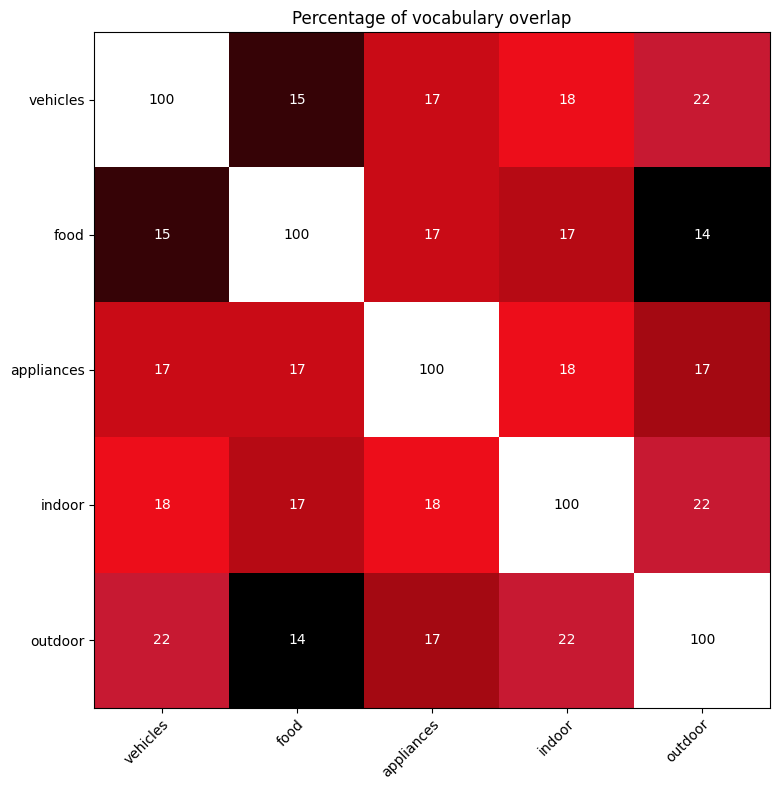

In [41]:
fig, ax = plt.subplots()
im = ax.imshow(merged_vocab_overlap, cmap='gist_stern')

# We want to show all ticks...
ax.set_xticks(np.arange(len(merged_vocabs_clean)))
ax.set_yticks(np.arange(len(merged_vocabs_clean)))
# ... and label them with the respective list entries
ax.set_xticklabels(merged_vocabs_clean.keys())
ax.set_yticklabels(merged_vocabs_clean.keys())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(merged_vocabs_clean)):
    for j in range(len(merged_vocabs_clean)):
        text = ax.text(j, i, int(merged_vocab_overlap[i, j]),
                       ha="center", va="center", color="w" if int(merged_vocab_overlap[i, j]) < 100 else "black")

ax.set_title("Percentage of vocabulary overlap")
fig.tight_layout()

print('Max overlap:', np.max(merged_vocab_overlap))
print('Min overlap:', np.min(merged_vocab_overlap))
print('Mean overlap:', np.mean(merged_vocab_overlap))
print('Stdev overlap:', np.std(merged_vocab_overlap))

plt.show()

Max difference: 0.012866986281623576
Min difference: -0.012866986281623576
Mean difference: 0.0
Stdev difference: 0.0070060204431722185


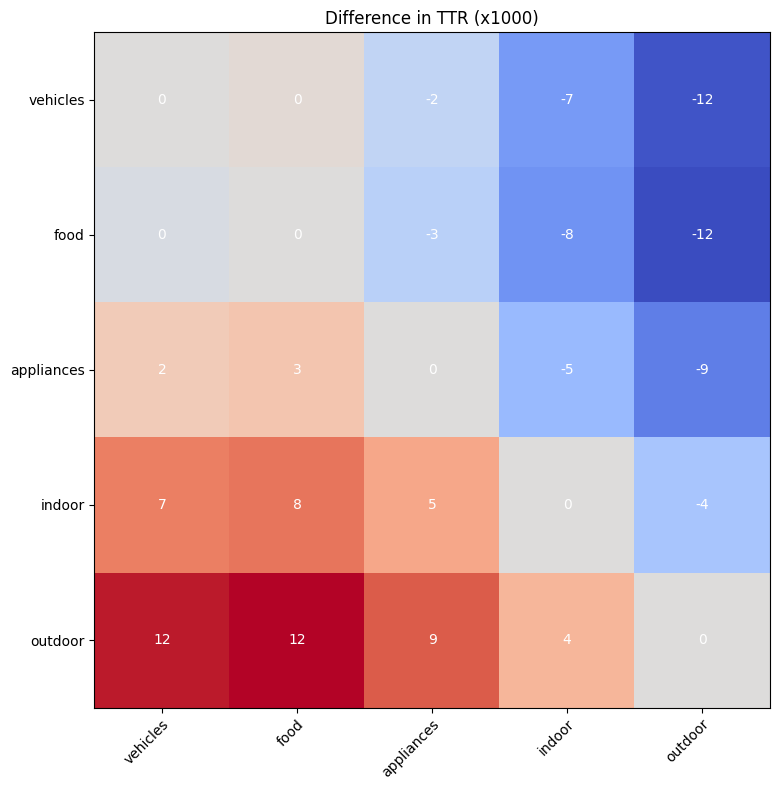

In [42]:
fig, ax = plt.subplots()
im = ax.imshow(merged_ttr_diffs, cmap='coolwarm')

# We want to show all ticks...
ax.set_xticks(np.arange(len(merged_vocabs_clean)))
ax.set_yticks(np.arange(len(merged_vocabs_clean)))
# ... and label them with the respective list entries
ax.set_xticklabels(merged_vocabs_clean.keys())
ax.set_yticklabels(merged_vocabs_clean.keys())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(merged_vocabs_clean)):
    for j in range(len(merged_vocabs_clean)):
        text = ax.text(j, i, int(merged_ttr_diffs[i, j] * 1000),
                       ha="center", va="center", color="w")

ax.set_title("Difference in TTR (x1000)")
fig.tight_layout()

print('Max difference:', np.max(merged_ttr_diffs))
print('Min difference:', np.min(merged_ttr_diffs))
print('Mean difference:', np.mean(merged_ttr_diffs))
print('Stdev difference:', np.std(merged_ttr_diffs))

plt.show()

### Domain-specific vocabularies

In [43]:
domain_specific_vocabs = {}
for d1 in image_domains:
    vocab_set_d1 = set(vocabs_clean[d1])
    
    for d2 in image_domains:
        
        if d1 == d2:
            continue
        
        vocab_set_d2 = set(vocabs_clean[d2])

        vocab_set_d1 = vocab_set_d1 - vocab_set_d2
       
    domain_specific_vocabs[d1] = vocab_set_d1
    print(d1, len(vocab_set_d1))
    print(vocab_set_d1)
    print()

car_motorcycle 145
{'axels', 'sideeways', 'pumps', 'typle', 'tri', 'glaring', 'pictu', 'tryke', 'sta', 'configuration', 'details', 'abiker', 'amazing', 'directiom', 'mororcycle', 'pitcure', 'wore', 'iy', 'it?\\', 'backed', 'pockets', 'correction', 'cutom', 'dope', 'mowed', 'fivce', 'cherry', 'motorcyle', 'crown', 'wbu', 'extra', 'hellow', 'pullin', 'saddlebag', 'mouthpiece', 'puling', 'no\\', 'pullcar', 'foront', 'browser', 'interscetion', 'rally', 'wher', 'blackmotorcycle', 'motorcylcle', 'mike', '5-wheeler', 'statio', 'canbe', 'scale', 'pipes', 'postion', 'pump', 'saddlebags', 'neatly', 'blike', 'blakc', 'tilts', 'average', 'mb', 'parket', 'white(silver', 'silve', 'ofother', 'suvs', 'cofefe', 'saddle', 'bakced', 'lo', 'oyou', 'spaces', 'whels', 'motors', 'crotch', 'attachment', 'unusual', 'moeorcycle', 'fllannel', 'no-', '.i', 'chopper', 'yopu', 'satchel', 'northeast', 'agreed', 'traile', 'froze', 'cowl', 'stooped', 'absolutely', 'fairing', 'prked', 'inf', 'thuis', 'prking', 'sack', 

### Shared vocabularies

In [44]:
printed = set()

for d1 in image_domains:
    vocab_set_d1 = set(vocabs_clean[d1])
    
    for d2 in image_domains:
        
        if d1 == d2:
            continue 
        if (d1, d2) in printed or (d2, d1) in printed:
            continue
        
        vocab_set_d2 = set(vocabs_clean[d2])
        
        overlap = vocab_set_d1 & vocab_set_d2
        
        print(d1, d2)
        print(overlap)
        print()
        
        printed.add((d1, d2))

car_motorcycle person_dog
{'left', 'hand', 'guys', 'jeans', 'previous', 'look', 'hold', 'blue', 'people', 'photo', 'man', 'putting', 'sign', 'tan', 'dressed', 'sideways', 'yep', 'old', 'thing', 'wearing', 'mouth', 'red', 'fence', 'round', 't', 'says', 'writing', 'highlighted', 'got', 'logo', 'close', 'jacket', 'time', 'hi', 'car', 'dude', 'person', 'light', 'riding', 'dogs', 'guy', 'type', 'hello', 'colored', 'near', 'yellow', 'little', 'hands', 'away', 'resting', 'shows', 'okay', 'sitting', 'pic', 'checkered', 'sorry', 'checked', 'right', 'like', 'brown', 'getting', 'shirt', 'dog', 'inside', 'think', 'dark', 'soda', 'head', 'buy', 'camera', 'vest', 'large', 'bed', 'face', 'giving', 'w', 'described', 'nt', 'holding', 'gold', 'great', 'clothes', 'park', 'floor', 'gray', 'standing', 'grey', 'picture', 'different', 'seen', 'orange', 'wear', 'plaid', 'black', 'mini', 'sure', 'looking', 'cool', 'color', 'maybe', 'tilted', 'pants', 'page', 'small', 'big', 'w/', 'directly', 'lap', 'cup', 'kid